# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [35]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

$$\frac{dL}{dw_0} =  {1/N} \cdot \sum_{i=1}^N (\frac{-exp(-y_i (w^Tx_i+w_0))\cdot y_i}{exp(-y_i (w^Tx_i+w_0)) + 1}) $$

$$\frac{dL}{dw} =  {1/N} \cdot \sum_{i=1}^N (\frac{-exp(-y_i (w^Tx_i+w_0)) \cdot y_i x_i} {exp(-y_i (w^Tx_i+w_0)) + 1}) + 2\beta w +\gamma sign(w)$$ 

### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [36]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return (1 / X.shape[0]) * np.sum(np.log(1 + np.exp(-y * (X.dot(w.T)
                                                             + w0)))
                                    ) + gamma * np.sum(np.abs(w)) + beta * np.sqrt(np.sum(np.square(w)))


#### 3. [0.25 points] Implement the gradient (as a function)

In [37]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    
    grad_w0 = (1 / X.shape[0]) * np.sum(-np.exp(-y * (X.dot(w.T) + w0)) * y / (
        1 + np.exp(-y * (X.dot(w.T) + w0))))
    
    grad_w = (1 / X.shape[0]) * (((-np.exp(-y * (X.dot(w.T) + w0))) * y  / (1 + (np.exp(-y * (X.dot(w.T) + w0))))
                ).dot(X)) + gamma * np.sign(w) + 2 * beta * w
    
    return grad_w, grad_w0

#### Check yourself

In [38]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

print("loss:")
print(loss(X, y, w, w0))
grad_w, grad_w0 = get_grad(X, y, w, w0)
print("grad_w0:")
print(grad_w0)
print("grad:")
print(grad_w)


assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

loss:
4.962818708164263
grad_w0:
-0.20782319347690745
grad:
[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [39]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [40]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=0.01, tolerance=0.000000001, max_iter= 25000, random_state=42,
                ignore_list = False):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w0 = 0
        self.w = None
        self.loss_arr = list()
        self.ignore_list = ignore_list;
        # you may additional properties if you wish
        
    def norm_2(w: List[float]):
        return np.sqrt(np.sum(np.square(w)))
    def fit(self, X, y):
        self.w = np.random.rand(X[0].size)
        if(not self.ignore_list):
            self.loss_arr.append(loss(X, y, self.w, self.w0))
        i = 0
        for i in range (1, self.max_iter):
            gr_w, gr_w0 = get_grad(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            gr_w_new  = self.w - gr_w * self.learning_rate
            gr_w0_new = self.w0 - gr_w0 * self.learning_rate

            if self.tolerance > np.sqrt(np.sum(np.square(-gr_w * self.learning_rate))):
                break
            
            self.w, self.w0 = gr_w_new, gr_w0_new
            if(not self.ignore_list):
                self.loss_arr.append(loss(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta))
            i += 1;
            
        return self
    
    def predict(self, X):
        # return vector of predicted labels for each object from X
        # your code here
        # print(np.sign(X.dot(self.w) + self.w0))
        predict = np.sign(X.dot(self.w) + self.w0);
        return predict
        
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)),\
                         1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])

In [41]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [42]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y, name = "Decision boundary"):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title(name, fontsize = 14)


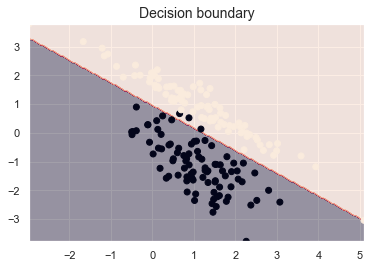

In [43]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0, 0.5, 'Loss')

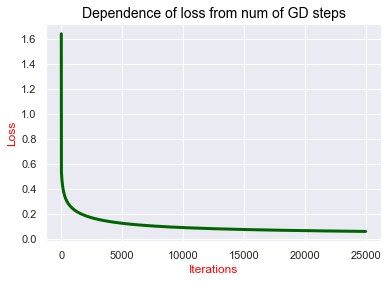

In [44]:
plt.plot(model.loss_arr,lw = 3, color = 'darkgreen')

plt.title("Dependence of loss from num of GD steps", fontsize = 14, color = 'black')
plt.xlabel("Iterations", color = 'red')
plt.ylabel('Loss', color = 'red')


## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

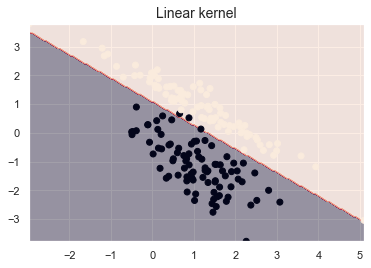

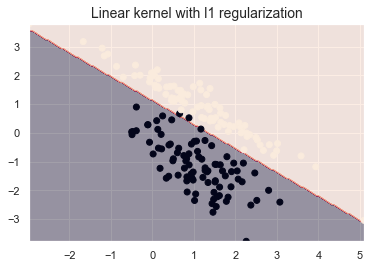

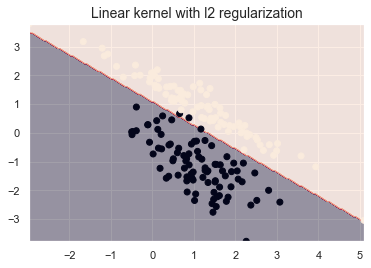

In [45]:
#Let's try different coefficients
from sklearn import svm
linear = svm.LinearSVC()
linear.fit(X, y)
plot_decision_boundary(linear, X, y, name = "Linear kernel")

linear_l1 = svm.LinearSVC(penalty = "l1", loss = "squared_hinge", dual = False)
linear_l1.fit(X, y)
plot_decision_boundary(linear_l1, X, y, name = "Linear kernel with l1 regularization")

linear_l2 = svm.LinearSVC(penalty = "l2", loss = "squared_hinge", dual = True)
linear_l2.fit(X, y)
plot_decision_boundary(linear_l2, X, y, name = "Linear kernel with l2 regularization")

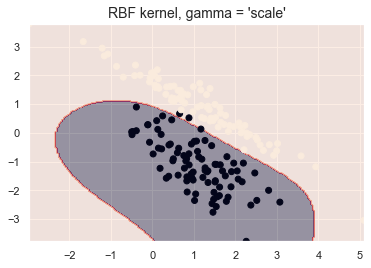

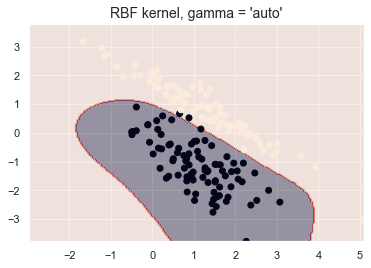

In [46]:
rbf_def = svm.SVC(kernel = 'rbf', gamma = 'scale', probability = True)
rbf_def.fit(X, y)
plot_decision_boundary(rbf_def, X, y, name = "RBF kernel, gamma = 'scale'")

rbf_auto = svm.SVC(kernel = 'rbf', gamma = 'auto', probability = True)
rbf_auto.fit(X, y)
plot_decision_boundary(rbf_auto, X, y, name = "RBF kernel, gamma = 'auto'")

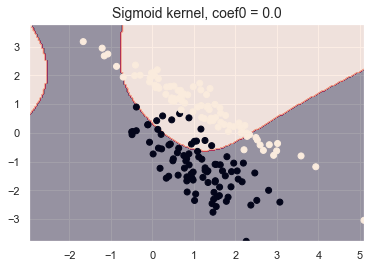

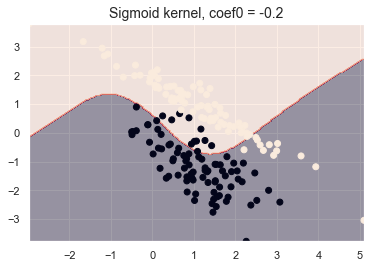

In [47]:
sigmoid = svm.SVC(kernel='sigmoid', probability = True, random_state=42)
sigmoid.fit(X, y)
plot_decision_boundary(sigmoid, X, y, name = "Sigmoid kernel, coef0 = 0.0")


sigmoid1 = svm.SVC(kernel='sigmoid', coef0 = -0.2, probability = True, random_state=42)
sigmoid1.fit(X, y)
plot_decision_boundary(sigmoid1, X, y, name = "Sigmoid kernel, coef0 = -0.2")

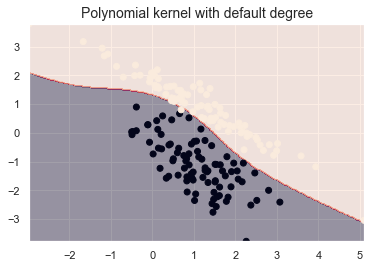

In [48]:
poly_svc = svm.SVC(kernel='poly', probability = True)
poly_svc.fit(X, y)
plot_decision_boundary(poly_svc, X, y, name = "Polynomial kernel with default degree")

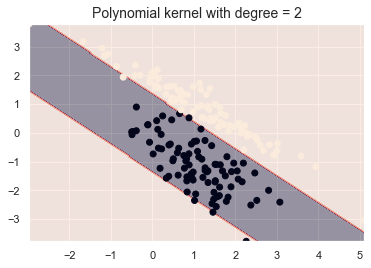

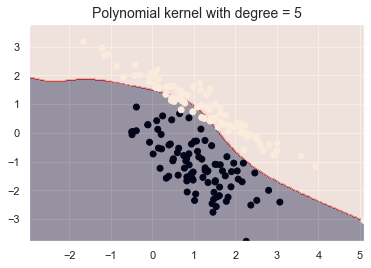

In [49]:
poly_svc = svm.SVC(kernel='poly', degree = 2, probability = True, random_state=42)
poly_svc.fit(X, y)
plot_decision_boundary(poly_svc, X, y, name = "Polynomial kernel with degree = 2")

poly_svc6 = svm.SVC(kernel='poly', degree = 5, probability = True, random_state=42)
poly_svc6.fit(X, y)
plot_decision_boundary(poly_svc6, X, y, name = "Polynomial kernel with degree = 5")

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [106]:
def roc_args(clf):
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    clf.fit(X, y)
    y_score = clf.predict_proba(X)[:, 1]
    pred = clf.predict(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y.shape[0]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
    return fpr[2], tpr[2]

In [112]:
def roc_sigmoid():
    clf = OneVsRestClassifier(
    svm.SVC(kernel="sigmoid", probability=True, random_state=42)
    )
    print("\nSigmoid:")
    return roc_args(clf)
    #roc_auc_score(y, y_score)
    

In [113]:
def roc_linear():
    linear = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=42)
    )
    print("\nLinear:")
    return roc_args(linear)

In [114]:
def roc_poly():
    poly = OneVsRestClassifier(
    svm.SVC(kernel="poly", degree = 3, probability=True, random_state=42)
    )
    print("\nPolynomial:")
    return roc_args(poly)

In [115]:
def roc_rbf():
    rbf = OneVsRestClassifier(
    svm.SVC(kernel="rbf", probability=True, random_state=42)
    )
    print("\nRbf:")
    return roc_args(rbf)


Sigmoid:
F1-measure:   0.80
Accuracy:   0.80

Linear:
F1-measure:   0.97
Accuracy:   0.97

Polynomial:
F1-measure:   0.99
Accuracy:   0.99

Rbf:
F1-measure:   0.98
Accuracy:   0.98


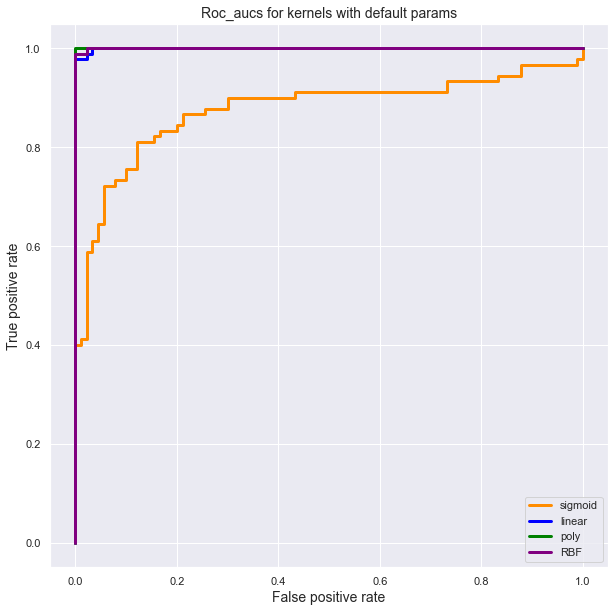

In [116]:

sigm1,sigm2 = roc_sigmoid()
lin1, lin2 = roc_linear()
poly1, poly2 = roc_poly()
rbf1, rbf2 = roc_rbf()

plt.figure(figsize=(10, 10))
lw = 3

plt.plot(sigm1, sigm2, color="darkorange", lw = lw, label = "sigmoid")
plt.plot(lin1, lin2, color="blue", lw = lw, label = 'linear')
plt.plot(poly1, poly2, color="green", lw = lw, label = 'poly')
plt.plot(rbf1, rbf2, color="purple", lw = lw, label = 'RBF')

plt.title("Roc_aucs for kernels with default params", fontsize = 14)
plt.xlabel("False positive rate", fontsize = 14)
plt.ylabel("True positive rate", fontsize = 14)
plt.legend(loc='best')
plt.show()




Sigmoid coef0 = 0.0: 
F1-measure:   0.80
Accuracy:   0.80

Sigmoid coef0 = -0.2: 
F1-measure:   0.83
Accuracy:   0.83

Poly, degree = 5: 
F1-measure:   0.94
Accuracy:   0.94

Poly, degree = 2: 
F1-measure:   0.97
Accuracy:   0.97


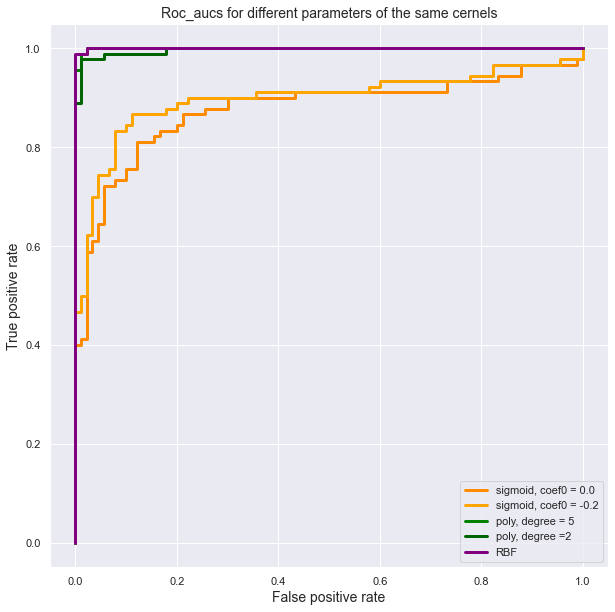

In [118]:
# Теперь построим roc_curve для SVC с измененными параметрами
print("\nSigmoid coef0 = 0.0: ")
sigm1,sigm2 = roc_args(OneVsRestClassifier(sigmoid))
print("\nSigmoid coef0 = -0.2: ")
sigm1coef,sigm2coef = roc_args(OneVsRestClassifier(sigmoid1))
print("\nPoly, degree = 5: ")
poly1, poly2 = roc_args(OneVsRestClassifier(poly_svc6))
print("\nPoly, degree = 2: ")
poly1deg2, poly2deg2 = roc_args(OneVsRestClassifier(poly_svc))

plt.figure(figsize=(10, 10))
lw = 3
plt.plot(sigm1, sigm2, color="darkorange", lw = lw,  label = "sigmoid, coef0 = 0.0")
plt.plot(sigm1coef, sigm2coef,color="orange", lw = lw,  label = "sigmoid, coef0 = -0.2")
plt.plot(poly1, poly2, color="green", lw = lw, label = 'poly, degree = 5')
plt.plot(poly1deg2, poly2deg2, color="darkgreen", lw = lw, label = 'poly, degree =2')
plt.plot(rbf1, rbf2, color="purple", lw = lw, label = 'RBF')

plt.title("Roc_aucs for different parameters of the same cernels", fontsize = 14)
plt.xlabel("False positive rate", fontsize = 14)
plt.ylabel("True positive rate", fontsize = 14)
plt.legend(loc='best')
plt.show()

In [58]:
# Если судить по desicion-boundary графикам наилучшие результаты показали polynomial, linear и RBF(с любой gamma). Причем эти результаты практически одинаковые,
# так как в RBF граница проходит по прямой линии. Чуть хуже справился polynomial, причем здесь коэффициэнт степени
# показал значительное влиянние. Хуже всех справился sigmoid ( с coef0 = -0.2 чуть лучше чем с default = 0.0, 
# он захватил меньше белых точек)

# Коэффициенты регуляризации l1 и l2 практически не поняли графики построенные линейной моделью, что хорошо, значит
# модель не переучивается

# Графики roc curve в целом подтверждают написанное выше. Polynomial показал практически идеальную кривую,
# полагаю, что это из-за отсутсвия ошибок первого рода (ни одна черная точка ложно не принята за белую) и 
# минимального количества ошибок второго рода. Также, что касается первого графика roc_aucs отличный результат 
# показали linear и rbf с дефолтными парметрами, сигмоид справился гораздо хуже

# Что касается второго графика (различные параметры), то polynomial с параметром degree = 5 показал результат хуже,
# чем с дефолтным degree = 3, а еще хуже с degree = 2.
# Однако, ранее самый худший sigmoid  (оранжевая кривая на втором графике) показал значительно 
# более хороший результат, если в него передается  параметр coef0 = -0.2, а не 
# дефолтный coef0 = 0.0, однако ему все равно далеко до его соперников

# В целом, некоторые kernel достаточно чувствительны к передаваемым параметрам, как например simoid или polynomial

# sources:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html,
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
# https://scikit-learn.org/stable/modules/svm.html

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [59]:
import glob
import string # for work with strings
import nltk 
import random
# nltk.download('punkt')

In [119]:
def get_books(files, author_books):
    for i in range (len(files)):
        author_books.append(open(files[i]))
    return author_books

In [120]:
def get_sentences(author_books):
    tokenized = list()
    for i in range (len(author_books)):
        text = author_books[i].read()
        tokenized_with_short = nltk.tokenize.sent_tokenize(text, language = 'russian')
        for i in range(len(tokenized_with_short)):
            if len(tokenized_with_short[i]) >= 15:
                tokenized.append(tokenized_with_short[i])
    return tokenized
#source https://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.sent_tokenize

In [62]:
#divide each text into sentences such that we will have two columns: sentence and target author,
#each row will contain one sentence and one target

gogol = list()
files = [f for f in glob.glob('/Users/antonzaripov/Downloads/archive-2/prose/Gogol/*.txt')]
gogol  = get_books(files, gogol )

chehkov = list()
files = [f for f in glob.glob('/Users/antonzaripov/Downloads/archive-2/prose/Chekhov/*.txt')]
chehkov = get_books(files, chehkov)

dostoevsky = list()
files = [f for f in glob.glob('/Users/antonzaripov/Downloads/archive-2/prose/Dostoevsky/*.txt')]
dostoevsky = get_books(files, dostoevsky)

tolstoy = list()
files = [f for f in glob.glob('/Users/antonzaripov/Downloads/archive-2/prose/Tolstoy/*.txt')]
tolstoy = get_books(files, tolstoy)

pushkin = list()
files = [f for f in glob.glob('/Users/antonzaripov/Downloads/archive-2/prose/Pushkin/*.txt')]
pushkin = get_books(files, pushkin)

turgenev = list()
files = [f for f in glob.glob('/Users/antonzaripov/Downloads/archive-2/prose/Turgenev/*.txt')]
turgenev = get_books(files, turgenev)

sentences = [[],[],[],[],[],[]]

#drop sentences where N symbols in a sentence < 15
sentences[0].extend(get_sentences(gogol))
sentences[1].extend(get_sentences(chehkov))
sentences[2].extend(get_sentences(dostoevsky))
sentences[3].extend(get_sentences(tolstoy))
sentences[4].extend(get_sentences(turgenev))
sentences[5].extend(get_sentences(pushkin))

# fix random state and randomly choose sentences 
# in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively

random.shuffle(sentences[0])
random.shuffle(sentences[1])
random.shuffle(sentences[2])
random.shuffle(sentences[3])
random.shuffle(sentences[4])
random.shuffle(sentences[5])

sentences[0] = sentences[0][:5000]
sentences[1] = sentences[1][:15000]
sentences[2] = sentences[2][:8000]
sentences[3] = sentences[3][:11000]
sentences[4] = sentences[4][:20000]
sentences[5] = sentences[5][:3000]


for i in range(6):
    print(len(sentences[i]))
    
# Все сделано, осталось создать DataFrame

# source https://docs.python.org/3/library/glob.html
# source https://stackoverflow.com/questions/61395024/select-file-in-a-directory-by-index-number

5000
15000
8000
11000
20000
3000


In [63]:
def df(sentences):
    dictionary = list()
    for i in range(len(sentences[1])):
        dictionary.append((sentences[1][i], 'Chekhov'))
    for i in range(len(sentences[0])):
        dictionary.append((sentences[0][i], 'Gogol'))
    for i in range(len(sentences[2])):
        dictionary.append((sentences[2][i], 'Dostoevsky'))
    for i in range(len(sentences[3])):
        dictionary.append((sentences[3][i], 'Tolstoy'))
    for i in range(len(sentences[5])):
        dictionary.append((sentences[5][i], 'Pushkin'))
    for i in range(len(sentences[4])):
        dictionary.append((sentences[4][i], 'Turgenev'))
    return pd.DataFrame(data = dictionary, columns=['sentences', 'authors'])

In [64]:
df = df(sentences)
display(df)

,sentences,authors
0,"Я молодая, здоровая, а муж у меня горбатый, по...",Chekhov
1,"— Оставь меня в покое, говорят тебе!",Chekhov
2,"Мы подбирали грибы и говорили, и когда она спр...",Chekhov
3,"Аня должна была ухаживать за пьяным отцом, што...",Chekhov
4,"Тем из них, которых природа одарила вкусом и и...",Chekhov
...,...,...
61995,"Отцу, вероятно, самому уже не хотелось более о...",Turgenev
61996,"– вскричал он, поднимаясь с места, – сюда, баб...",Turgenev
61997,Одевалась она изысканно.,Turgenev
61998,"Вот, дескать, откровенный человек… И, боже мой!",Turgenev


In [65]:
# Теперь нужно сделать preprocess, почистить датасет

In [66]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
word_tokenizer = nltk.WordPunctTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antonzaripov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
def process_data(data):
    texts = []
    targets = []
    digs = [str(x) for x in np.arange(1, 10000)]

    for item in data['sentences']:
        extra = ['—', '...', '».', ').', '?»', '!»', '–', '…', '.,']
        text_lower = item.lower() # convert words in a text to lower case
        tokens     = word_tokenizer.tokenize(text_lower) # splits the text into tokens (words)
        
        # remove punct and stop words from tokens
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words 
                                              and word not in string.digits 
                                             and word not in extra and len(word) > 1)and word not in digs]
        
        texts.append(tokens) # collect the text tokens
    
    return texts

In [68]:
new_df = df
new_df['sentences'] = process_data(new_df)

for i in range(30990, 30999):
    print(f"{new_df['sentences'][i]} author: {new_df['authors'][i]}")   

['одних', 'бьешь', 'другие', 'лезут', '--', 'сделаешь'] author: Tolstoy
['естественно'] author: Tolstoy
['случае', 'злодейства', 'требуем', 'поступок', 'наказания', 'случае', 'добродетели', 'ценим', 'поступок'] author: Tolstoy
['сказал', 'князь', 'сыну', 'указывая', 'архитектора'] author: Tolstoy
['спросила', 'марьяну', 'устенька'] author: Tolstoy
['--', 'спросил'] author: Tolstoy
['дядя', 'князь', 'висарион', 'удалить', 'молодого', 'человека', 'общества', 'перевез', 'москву'] author: Tolstoy
['les', 'souverains'] author: Tolstoy
['молчаливый', 'вопрос', 'казалось', 'собеседник', 'хотел', 'ответить'] author: Tolstoy


In [69]:
# apply either stemming or lemmatization of the words (on your choice)
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
print(len(new_df['sentences']))

for i in tqdm_notebook(range(len(new_df['sentences']))):           # tqdm_notebook creates the process bar below :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in new_df['sentences'][i]] # apply lemmatization to each word in a text
    new_df['sentences'][i] = ' '.join(text_lemmatized)
    if(i<5):
        print(new_df['sentences'][i])
        

62000


молодой здоровый муж горбатый постылый крутой плохой дюдить проклятый
оставить покой говорить ты
подбирать гриб говорить спрашивать заходить вперёд видеть мой лицо
аня должный ухаживать пьяный отец штопать брат чулок ходить рынок хвалить красота молодость изящный манера казаться весь свет видеть дешёвый шляпка дырочка ботинок замазать чернила
который природа одарить вкус инстинкт красота этот лёгкий небрежность одежда придавать особый прелесть



In [70]:
#
sec_df = new_df.copy()
#new_df = new_df.iloc[1: , :]
#new_df.append(['садовник прислать говорить в столовая поставить', 'Chekhov'])
display(sec_df)

,sentences,authors
0,молодой здоровый муж горбатый постылый крутой ...,Chekhov
1,оставить покой говорить ты,Chekhov
2,подбирать гриб говорить спрашивать заходить вп...,Chekhov
3,аня должный ухаживать пьяный отец штопать брат...,Chekhov
4,который природа одарить вкус инстинкт красота ...,Chekhov
...,...,...
61995,отец вероятно сам хотеться оставаться дача вид...,Turgenev
61996,вскричать подниматься место сюда баба !..,Turgenev
61997,одеваться изысканно,Turgenev
61998,дескать откровенный человек бог,Turgenev


In [71]:
from sklearn.feature_extraction.text import CountVectorizer

#vectorize words using both bag of words and tf-idf (use sklearn)
vectorizer = CountVectorizer(max_features = 50)
vectorizer.fit(new_df['sentences'])

# The top 10 words
print(vectorizer.get_feature_names()[:10])


['бог', 'быть', 'ваш', 'весь', 'видеть', 'время', 'всё', 'глаз', 'глядеть', 'говорить']


In [121]:
train_texts = new_df['sentences']
train_X = vectorizer.transform(train_texts)
train_X.todense()[:4]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
vectorizer_idf = TfidfVectorizer(max_features = 50) # select the top 100 words
vectorizer_idf.fit(new_df['sentences'])

# The top 10 words
vectorizer_idf.get_feature_names()[:10]

['бог',
 'быть',
 'ваш',
 'весь',
 'видеть',
 'время',
 'всё',
 'глаз',
 'глядеть',
 'говорить']

In [74]:
train_X = vectorizer_idf.transform(train_texts)
train_X.todense()[:4]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.61825125,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 

In [ ]:
# observe and describe the difference between vectorized output
# В первом случае (Bag of words) нам возвращается вектор из 50 чисел соответствующий каждому предложению.
# Натуральные числа в этом векторе говорят о наличии либо об отсутсвии соотв. слова в предложении и о 
# числе его повторов. Во втором случае (Tf-idf) нам показывается немного другое, а именно важность этого слова
# (промежуток от 0 до 1). В обоих случаях матрицы получились разреженные.


###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models


In [75]:
from sklearn.svm import SVC
from sklearn.metrics import *
# choose two authors from the dataset that you have formed in the previous task
df2 = new_df.loc[new_df.authors.str.contains('Dostoevsky'), :]
df1 = new_df.loc[new_df.authors.str.contains('Tolstoy'), :]
df3 = pd.concat([df2,df1])
display(df3)


,sentences,authors
20000,убитый нелли страшно оскорбить подняться пожал...,Dostoevsky
20001,воскликнуть видеть пропасть,Dostoevsky
20002,фортуна заесть благодетель оттого шут,Dostoevsky
20003,сказать,Dostoevsky
20004,-- любить,Dostoevsky
...,...,...
38995,накормить ночь спать ребёнок умереть умереть у...,Tolstoy
38996,quelle fichue id &# aller enterrer dans les st...,Tolstoy
38997,кто думать дурной любить жалеть,Tolstoy
38998,княжна марья узнать газета рана брат иметь нем...,Tolstoy


In [76]:
# check the balance of the classes
print(f"Tolstoy: {df3[df3['authors'] == 'Tolstoy'].count()}")
print()
print(f"Dostoevsky: {df3[df3['authors'] == 'Dostoevsky'].count()}")   

Tolstoy: sentences    11000
authors      11000
dtype: int64

Dostoevsky: sentences    8000
authors      8000
dtype: int64


In [77]:
#sem 6 
def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
    labels = ['negative','positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

In [91]:
# divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)

train_texts, test_texts, train_y, test_y = train_test_split(df3['sentences'], [1 if x == 'Tolstoy'  else 0 
                                                                               for x in df3['authors'] ]
                                                            , test_size = 0.7, random_state = 0
                                                            , stratify = df3['authors'])
vectorizer.fit(train_texts)
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)


Precision:   0.72
Recall:   0.68
F1-measure:   0.68
Accuracy:   0.71
ROC-AUC  =    0.78




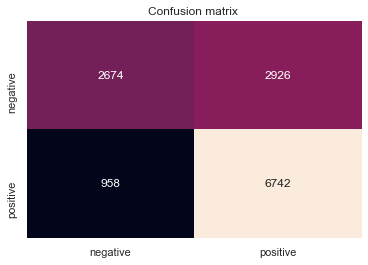

In [86]:
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)
clf = SVC(probability=True)
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
show_results(test_y, pred, proba)

Precision:   0.74
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.82




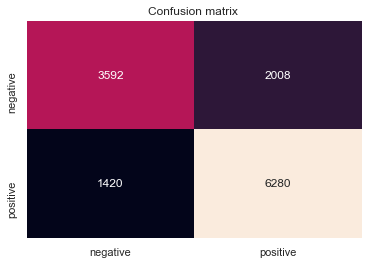

In [85]:
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)
clf = LogisticRegression(verbose = False)
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
show_results(test_y, pred, proba)

In [ ]:
# В целом результаты нормальные, но попробуем подобрать параметры чтобы еще их улучшить

Best parameters:  {'C': 1, 'class_weight': None, 'penalty': 'l2'}
Precision:   0.74
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.82




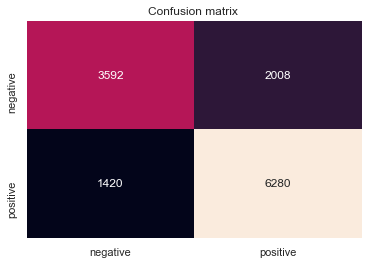

In [84]:
# using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks


parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight' : ['balanced',None],\
              'penalty':['l1', 'l2', 'elasticnet']}
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)
svr = LogisticRegression(verbose = False)
clf = GridSearchCV(svr, parameters, scoring = 'f1')
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
print('Best parameters: ', clf.best_params_)
show_results(test_y, pred, proba)

Number of features:  100
Precision:   0.61
Recall:   0.58
F1-measure:   0.57
Accuracy:   0.62
ROC-AUC  =    0.66




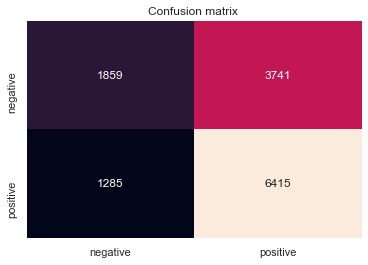





Number of features:  1000
Precision:   0.70
Recall:   0.69
F1-measure:   0.69
Accuracy:   0.70
ROC-AUC  =    0.78




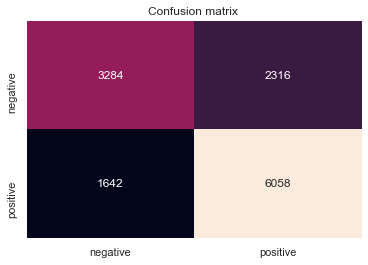





Number of features:  10000
Precision:   0.74
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.82




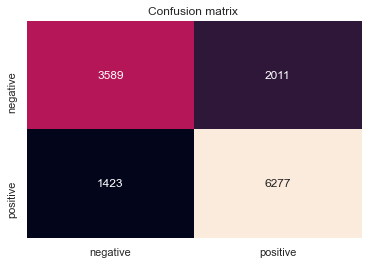





Number of features:  30000
Precision:   0.74
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.82




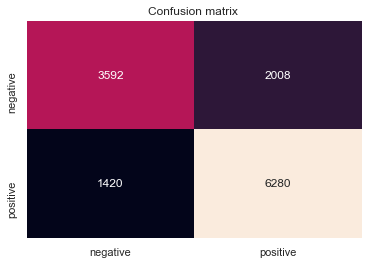





Number of features:  60000
Precision:   0.74
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.82




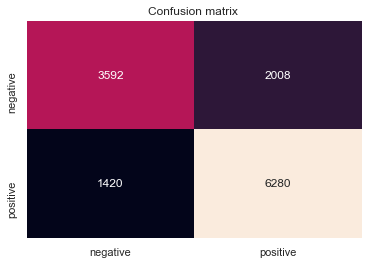





Number of features:  100000
Precision:   0.74
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.74
ROC-AUC  =    0.82




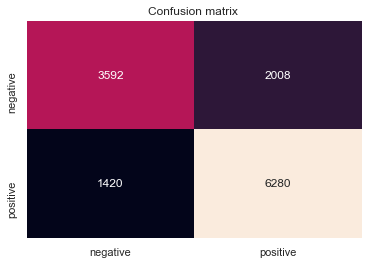

In [83]:
# make several plots to address the dependence between F1 score and parameters
best_params = {'C': 1, 'class_weight': None, 'penalty': 'l2'}
f1s = []
word_grid = [100, 1000, 10000, 30000, 60000, 100000]
for max_features in word_grid:
    vectorizer = CountVectorizer(max_features = max_features)
    vectorizer.fit(train_texts)
    train_X = vectorizer.transform(train_texts)
    test_X  = vectorizer.transform(test_texts)
    clf = LogisticRegression(**best_params)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    proba  = clf.predict_proba(test_X)
    print('Number of features: ', max_features)
    show_results(test_y, pred, proba)
    print('\n\n\n')
    f1s.append(f1_score(test_y, pred))

Text(0.5, 1.0, 'F1 result')

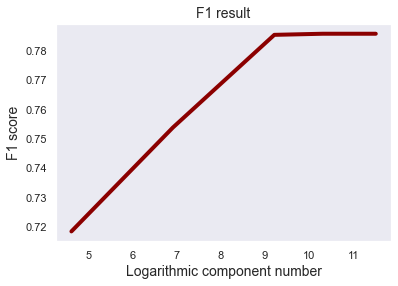

In [92]:
plt.plot([np.log(x) for x in word_grid], f1s, lw = 4, color = 'darkred')
plt.grid()
plt.xlabel('Logarithmic component number', fontsize = 14)
#plt.xlabels([str(x) for x in word_grid])
plt.ylabel('F1 score', fontsize = 14)

plt.title('F1 result', fontsize = 14)

In [ ]:
# При количестве фичей до 10000 Ф1 растет, затем останавливается. 
# Из графика выше видно, что F1 score резко возрастает до comp. number = 7, затем до comp.number = 9 его 
# рост слегка замедляется, а после 9 и вовсе останавливается на отметке чуть ниже 0.79

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve 

In [93]:
def roc_args(clf):
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    clf.fit(X, y)
    y_score = clf.predict_proba(X)[:, 1]
    fpr = dict()
    tpr = dict()
    threshold = dict()
    roc_auc = dict()
    n_classes = y.shape[0]
    for i in range(n_classes):
        fpr[i], tpr[i], threshold[i] = roc_curve(y, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr[2], tpr[2], threshold[2]

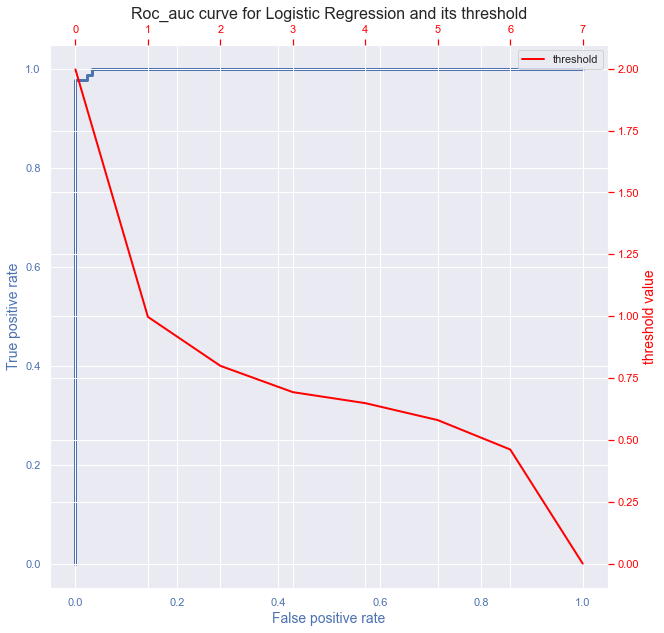

In [94]:
#Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots
svr = LogisticRegression(verbose = False)
log1,log2,log3 = roc_args(svr)
fig = plt.figure(figsize=(10, 10))
lw = 3
ax1=fig.add_subplot()
ax2=fig.add_subplot( frame_on=False)


ax1.plot(log1,log2, color="C0", lw = 3, label = 'roc_auc curve')
ax1.set_xlabel("False positive rate", fontsize = 14, color="C0")
ax1.set_ylabel("True positive rate", fontsize = 14, color="C0")
ax1.tick_params(axis='x', colors="C0")
ax1.tick_params(axis='y', colors="C0")

ax2.plot(log3, color="red", lw = 2, label = 'threshold')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_ylabel("threshold value", fontsize = 14, color="red")
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")

plt.title("Roc_auc curve for Logistic Regression and its threshold", fontsize = 16)
plt.legend(loc='best')
plt.show()
# source https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth
# https://www.tutorialspoint.com/how-to-add-a-second-x-axis-in-matplotlib

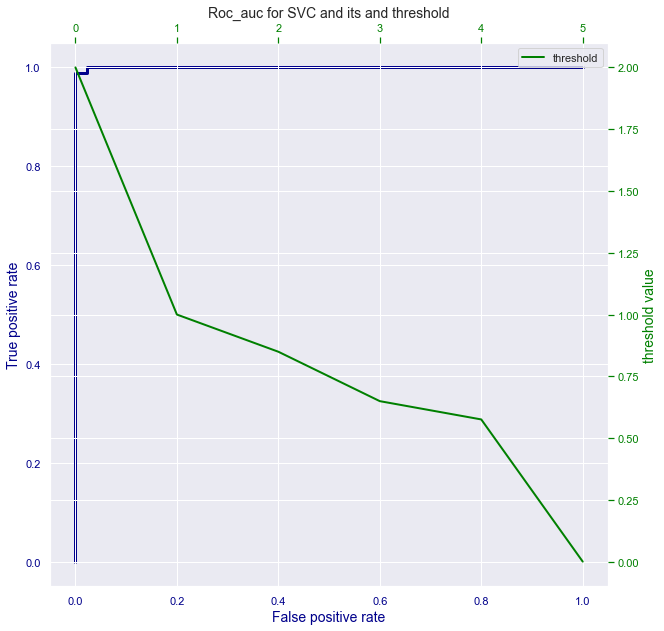

In [95]:
clf = SVC(probability=True)
svc1,svc2,svc3 = roc_args(clf)
fig = plt.figure(figsize=(10, 10))
lw = 3
ax1=fig.add_subplot()
ax2=fig.add_subplot( frame_on=False)


ax1.plot(svc1,svc2, color="darkblue", lw = 3, label = 'roc_auc curve')
ax1.set_xlabel("False positive rate", fontsize = 14, color="darkblue")
ax1.set_ylabel("True positive rate", fontsize = 14, color="darkblue")
ax1.tick_params(axis='x', colors="darkblue")
ax1.tick_params(axis='y', colors="darkblue")

ax2.plot(svc3, color="green", lw = 2, label = 'threshold')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_ylabel("threshold value", fontsize = 14, color="green")
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="green")
ax2.tick_params(axis='y', colors="green")

plt.title("Roc_auc for SVC and its and threshold", fontsize = 14)
plt.legend(loc='best')
plt.show()

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [152]:
# divide the data into train and test samples with 0.7 split rate
train_texts, test_texts, train_y, test_y = train_test_split(new_df['sentences'],new_df['authors'] 
                                                            , test_size = 0.7, random_state = 0
                                                            )

In [153]:
vectorizer = TfidfVectorizer(max_features = 100)
vectorizer.fit(train_texts)
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)


train_y = np.array(train_y)
test_y = np.array(test_y)
train_y_ = np.zeros(train_y.shape)
test_y_ = np.zeros(test_y.shape)

train_y_[train_y == 'Gogol'] = 0
test_y_[test_y == 'Gogol'] = 0

train_y_[train_y == 'Chekhov'] = 1
test_y_[test_y == 'Chekhov'] = 1

train_y_[train_y == 'Tolstoy'] = 2
test_y_[test_y == 'Tolstoy'] = 2

train_y_[train_y == 'Dostoevsky'] = 3
test_y_[test_y == 'Dostoevsky'] = 3

train_y_[train_y == 'Pushkin'] = 4
test_y_[test_y == 'Pushkin'] = 4

train_y_[train_y == 'Turgenev'] = 5
test_y_[test_y == 'Turgenev'] = 5

In [155]:
parameters = {'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100], \
              'estimator__class_weight' : ['balanced', None], 'estimator__penalty':['l1', 'l2', 'elasticnet']}

my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')



svr = OneVsOneClassifier(LogisticRegression(verbose = False))
clf = GridSearchCV(svr, parameters, scoring=my_scorer)
clf.fit(train_X, train_y_)
predict = clf.predict(test_X)
print('nOneVsOne Strategy')
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(clf.score(test_X, test_y_)))




OneVsOne Strategy
Best parameters:  {'estimator__C': 1, 'estimator__class_weight': None, 'estimator__penalty': 'l2'}
F1 score  =   0.35


In [158]:
def show_onevsone(test_y, pred):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print('\n')
    labels = ['Gogol','Chekhov', 'Tolstoy','Dostoevsky','Pushkin', 'Turgenev']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

Precision:   0.27
Recall:   0.21
F1-measure:   0.17
Accuracy:   0.35




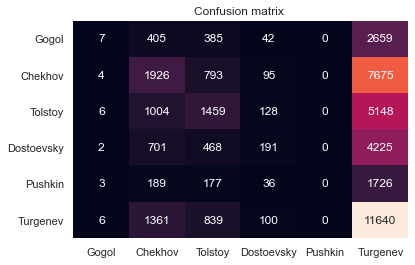

In [161]:
show_onevsone(test_y_, predict)